In [339]:
# %% Import các thư viện cần thiết
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [340]:
# %% Đọc dữ liệu và tiền xử lý
data = pd.read_csv("botswana_bank_customer_churn.csv")

In [341]:
# Hiển thị thông tin cơ bản
print("Thông tin dữ liệu:")
print(data.info())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RowNumber                        115640 non-null  int64  
 1   CustomerId                       115640 non-null  object 
 2   Surname                          115640 non-null  object 
 3   First Name                       115640 non-null  object 
 4   Date of Birth                    115640 non-null  object 
 5   Gender                           115640 non-null  object 
 6   Marital Status                   115640 non-null  object 
 7   Number of Dependents             115640 non-null  int64  
 8   Occupation                       115640 non-null  object 
 9   Income                           115640 non-null  float64
 10  Education Level                  115640 non-null  object 
 11  Address                          115640 non-nu

In [342]:
print(f"Số bản ghi: {data.shape[0]}, Số trường: {data.shape[1]}")
print("\nThống kê dữ liệu:")
print(data.describe().T)

Số bản ghi: 115640, Số trường: 25

Thống kê dữ liệu:
                          count           mean           std      min  \
RowNumber              115640.0   57820.500000  33382.536902     1.00   
Number of Dependents   115640.0       2.502923      1.707249     0.00   
Income                 115640.0   52641.363046  27429.756390  5000.96   
Customer Tenure        115640.0      15.490591      8.654217     1.00   
Credit Score           115640.0     574.299775    159.067499   300.00   
Credit History Length  115640.0      15.546602      8.654630     1.00   
Outstanding Loans      115640.0   25502.731792  14127.859827  1000.43   
Churn Flag             115640.0       0.121878      0.327147     0.00   
Balance                115640.0  124639.209748  72210.476638     1.06   
NumOfProducts          115640.0       2.999274      1.411361     1.00   
NumComplaints          115640.0       4.991724      3.159283     0.00   

                             25%         50%          75%        max  

In [343]:
print(data.head())

   RowNumber                            CustomerId   Surname First Name  \
0          1  83ef0b54-35f6-4f84-af58-5653ac0c0dc4     Smith       Troy   
1          2  009f115a-e5ca-4cf4-97d6-530140545e4e  Sullivan    Katrina   
2          3  66309fd3-5009-44d3-a3f7-1657c869d573    Fuller      Henry   
3          4  b02a30df-1a5f-4087-8075-2a35432da641     Young    Antonio   
4          5  0d932e5b-bb3a-4104-8c83-f84270f7f2ea  Andersen       John   

  Date of Birth  Gender Marital Status  Number of Dependents  \
0     8/29/1987    Male       Divorced                     3   
1      2/7/2000  Female        Married                     1   
2      2/3/1954  Female         Single                     1   
3     1/15/1991  Female       Divorced                     5   
4      4/8/1992  Female       Divorced                     2   

                        Occupation    Income  ...  \
0      Information systems manager  77710.14  ...   
1               Charity fundraiser  58209.87  ...   
2  Te

In [344]:
# Kiểm tra missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
RowNumber                               0
CustomerId                              0
Surname                                 0
First Name                              0
Date of Birth                           0
Gender                                  0
Marital Status                          0
Number of Dependents                    0
Occupation                              0
Income                                  0
Education Level                         0
Address                                 0
Contact Information                     0
Customer Tenure                         0
Customer Segment                        0
Preferred Communication Channel         0
Credit Score                            0
Credit History Length                   0
Outstanding Loans                       0
Churn Flag                              0
Churn Reason                       101546
Churn Date                         101546
Balance                                 0
NumOfProducts     

In [345]:
# Xử lý giá trị thiếu
numerical_cols = data.select_dtypes(include=[np.number]).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

if "Date of Birth" in data.columns:
    data["Date of Birth"] = pd.to_datetime(data["Date of Birth"], errors="coerce")
    data["Age"] = (pd.to_datetime("today") - data["Date of Birth"]).dt.days // 365
    data.drop(columns=["Date of Birth"], inplace=True)

In [346]:
# Loại bỏ các cột không cần thiết
columns_to_drop = [
    'RowNumber', 'CustomerId', 'Surname', 'First Name',
    'Occupation', 'Address', 'Contact Information',
    'Churn Reason', 'Churn Date'
]
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

In [347]:
# %% Mã hóa các trường phân loại
categorical_cols = ["Gender", "Marital Status", "Education Level", "Customer Segment", "Preferred Communication Channel"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# %% Chuẩn hóa các trường liên tục
continuous_cols = ["Income", "Balance", "Outstanding Loans", "Credit Score", "Customer Tenure", "Credit History Length", "Age"]
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

In [348]:
# Hiển thị dữ liệu đã chuẩn hóa
print(data.head())

   Number of Dependents    Income  Customer Tenure  Credit Score  \
0                     3  0.913930         1.676578     -1.114625   
1                     1  0.203011         1.329925      0.570202   
2                     1 -1.562082        -0.172239      0.884535   
3                     5 -1.369044         0.867720      1.085709   
4                     2  0.294761         0.752169     -0.159051   

   Credit History Length  Outstanding Loans  Churn Flag   Balance  \
0               0.976753           1.164867           0  1.200937   
1              -0.640885          -1.174002           0 -1.301956   
2               0.630116           1.257649           0 -0.175635   
3               0.167934          -0.539014           0  1.060078   
4               1.092298           0.508509           0 -0.889736   

   NumOfProducts  NumComplaints       Age  Gender_Male  \
0              1              0 -0.589943         True   
1              4              1 -1.367175        False   
2 

In [349]:
# Tách dữ liệu và nhãn
X = data.drop("Churn Flag", axis=1)
y = data["Churn Flag"]

In [350]:
# %% Cân bằng dữ liệu bằng SMOTE nếu cần
if y.value_counts(normalize=True).min() < 0.4:
    print("\nCân bằng dữ liệu bằng SMOTE...")
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)


Cân bằng dữ liệu bằng SMOTE...



Phương sai giải thích bởi PCA:
[0.41292131 0.5380573  0.62467921 0.67128228 0.71291005 0.75432958
 0.79552397 0.83645007 0.87677021 0.9121658 ]


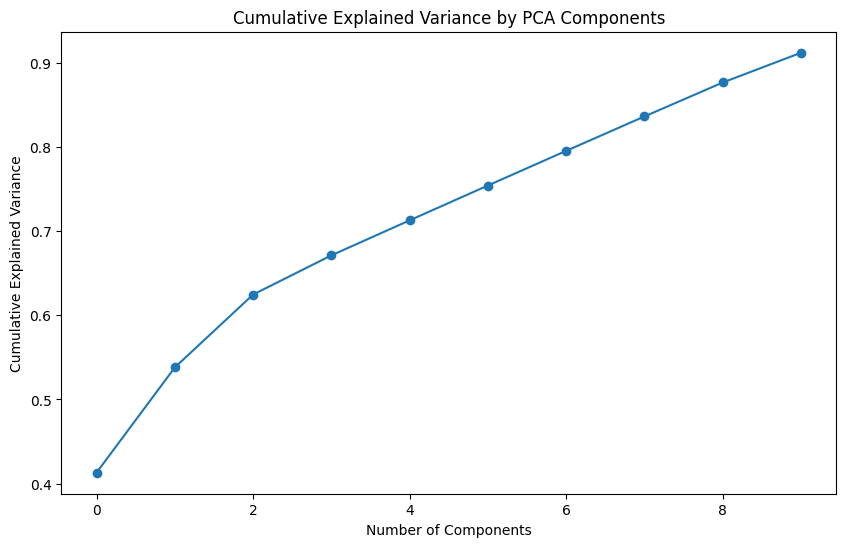

Phương sai giải thích bởi PCA: [0.41292131 0.125136   0.0866219  0.04660307 0.04162778 0.04141953
 0.04119439 0.04092611 0.04032013 0.0353956 ]
Tổng phương sai giữ lại: 0.9121658049583408


In [351]:
# %% Giảm chiều với PCA
pca = PCA(n_components=0.9)  # Giữ lại 90% phương sai
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print("\nPhương sai giải thích bởi PCA:")
print(np.cumsum(pca.explained_variance_ratio_))

# Biểu đồ phương sai tích lũy
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()

# In tổng phương sai giữ lại
print("Phương sai giải thích bởi PCA:", explained_variance)
print("Tổng phương sai giữ lại:", sum(explained_variance))


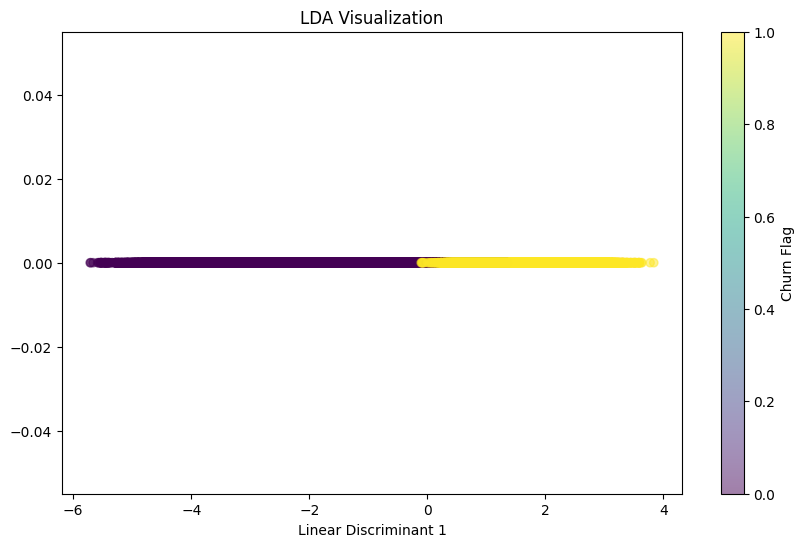

In [352]:
# %% Giảm chiều với LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0], [0] * len(X_lda), c=y, cmap="viridis", alpha=0.5)
plt.title("LDA Visualization")
plt.colorbar(label="Churn Flag")
plt.xlabel("Linear Discriminant 1")
plt.show()


In [353]:
# %% Hàm phân loại sử dụng Gaussian Naive Bayes
def gaussian_naive_bayes(X_transformed, y, name="Gaussian Naive Bayes"):
    """Áp dụng GaussianNB trên dữ liệu."""
    splits = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
    print(f"\nPhân loại với {name}:")

    results = {}
    for train_size, test_size in splits:
        # Chia dữ liệu train-test
        X_train, X_test, y_train, y_test = train_test_split(
            X_transformed, y, train_size=train_size, random_state=42
        )

        # Huấn luyện GaussianNB
        model = GaussianNB()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Đánh giá mô hình
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"\nTrain-Test Split: {train_size*100}-{test_size*100}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        results[f"{train_size*100}-{test_size*100}"] = {
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy
        }

    return results

In [354]:
# Phân loại với dữ liệu gốc
results_original = gaussian_naive_bayes(X, y, name="Dữ liệu gốc")



Phân loại với Dữ liệu gốc:

Train-Test Split: 80.0-20.0
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     20253
           1       0.91      0.98      0.94     20366

    accuracy                           0.94     40619
   macro avg       0.94      0.94      0.94     40619
weighted avg       0.94      0.94      0.94     40619

Confusion Matrix:
[[18210  2043]
 [  336 20030]]

Train-Test Split: 70.0-30.0
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     30380
           1       0.91      0.98      0.94     30548

    accuracy                           0.94     60928
   macro avg       0.94      0.94      0.94     60928
weighted avg       0.94      0.94      0.94     60928

Confusion Matrix:
[[27281  3099]
 [  500 30048]]

Train-Test Split: 60.0-40.0
Classification Report:
              precision    recall  f1-score   support

         

In [355]:
# Phân loại với dữ liệu PCA
results_pca = gaussian_naive_bayes(X_pca, y, name="Dữ liệu PCA")


Phân loại với Dữ liệu PCA:

Train-Test Split: 80.0-20.0
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     20253
           1       0.89      0.96      0.92     20366

    accuracy                           0.92     40619
   macro avg       0.92      0.92      0.92     40619
weighted avg       0.92      0.92      0.92     40619

Confusion Matrix:
[[17714  2539]
 [  755 19611]]

Train-Test Split: 70.0-30.0
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.91     30380
           1       0.89      0.96      0.92     30548

    accuracy                           0.92     60928
   macro avg       0.92      0.92      0.92     60928
weighted avg       0.92      0.92      0.92     60928

Confusion Matrix:
[[26603  3777]
 [ 1234 29314]]

Train-Test Split: 60.0-40.0
Classification Report:
              precision    recall  f1-score   support

         

In [356]:
# Phân loại với dữ liệu LDA
results_lda = gaussian_naive_bayes(X_lda, y, name="Dữ liệu LDA")


Phân loại với Dữ liệu LDA:

Train-Test Split: 80.0-20.0
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     20253
           1       0.95      0.99      0.97     20366

    accuracy                           0.97     40619
   macro avg       0.97      0.97      0.97     40619
weighted avg       0.97      0.97      0.97     40619

Confusion Matrix:
[[19282   971]
 [  196 20170]]

Train-Test Split: 70.0-30.0
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     30380
           1       0.95      0.99      0.97     30548

    accuracy                           0.97     60928
   macro avg       0.97      0.97      0.97     60928
weighted avg       0.97      0.97      0.97     60928

Confusion Matrix:
[[28936  1444]
 [  298 30250]]

Train-Test Split: 60.0-40.0
Classification Report:
              precision    recall  f1-score   support

         